## data preprocess
### data cleaning on quality issues
For each feature identify the following problems
* Inconsistent values
* Duplicate records
Duplicate should be removed immediately from database/dataset
* Missing values
* Invalid values
* Outliers

### data transformation
scaling, transformation, feature selection, dim reduction, data manipulation
* scaling - normalization
* transformation - category vectorize
* feature selection/engineering

In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *

In [2]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views(materialize=True)

### county_properties, property_features, property_addresses
* restrict properties to land_use_code = 1, land_use_subcode: [11, 17]  ~ 711255
* year_built has 2 digit, it's not clear if it's 19xx or 20xx, eg '10' could be 1910 or 2010
* 1784 properties have sqft = 0
* 146 properties missed address
* final valid: 709325

### county_addresses
* Among 709325 valid properties, 673826(95%) have addresses encoded as geo lon/lat with rank > 20

### county_transactions ###
* (duplicate) records in transactions: can be identified by (pin, trailer_pin, doc_date)?
* Lots of transactions with code 'M' seem to have weird sold_price value?
* (invalid values) 174764 transactions have price = 0, they all appear after 2009-01-01
* (outlier or invalid?) weird values: sqft > 1000ft and sold_price < 50000 in year 2017, eg Borrego Springs
* (missing records) some transactions that we knew didn't exist in data

* valid transactions: 1449003


In [3]:
# all transactions
df_all = ds.get_view_df('property_address_transactions')
print(df_all.shape)
df_all[:3]

(1512560, 25)


,pin,land_use_subcode,year_built,sqft,usable_sqft,acre,num_bed,num_bath,pool,view,...,unit_no,city,zip,address,new_address,lon,lat,sold_price,date,sqft_price
0,4865521400,11,1979.0,2058,13000.0,0,4.0,3.0,N,Y,...,None,EL CAJON,92020,"1719 PRIMROSE DR, EL CAJON, CA 92020","1719 Primrose Dr, El Cajon, CA 92020",-116.98746,32.78840,140000,1983-01-03,68
1,3468012457,17,1978.0,1332,NaN,0,2.0,2.0,None,N,...,105,LA JOLLA,92037,"8452 VIA SONOMA , LA JOLLA, CA 92037","8452 Sonoma Via, San Diego, CA 92037",-117.23114,32.85944,115000,1983-01-03,86
2,5180821700,11,1982.0,2129,NaN,0,4.0,3.0,Y,N,...,None,EL CAJON,92019,"2034 SECA ST, EL CAJON, CA 92019","2034 Seca St, Rancho San Diego, CA 92019",-116.91740,32.75339,128790,1983-01-03,60


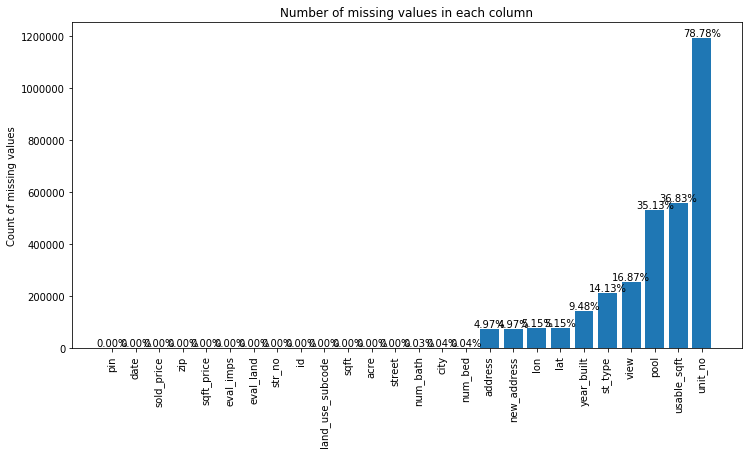

In [72]:
missing_df = df_all.isnull().sum(axis=0)
plot_bar(missing_df, ylabel="Count of missing values", title="Number of missing values in each column", total=df_all.shape[0], order=True)

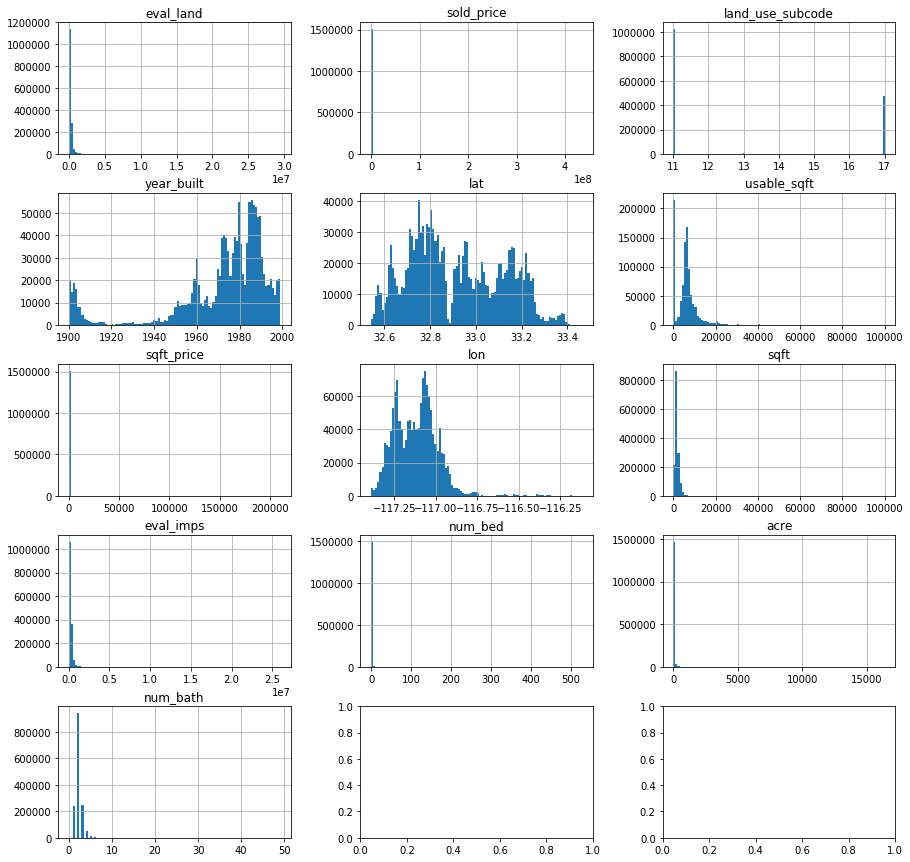

In [5]:
# check various feature distribution
columns = set(df_all.columns) - set(['pin'])
plot_feature_histogram(df_all, list(columns))

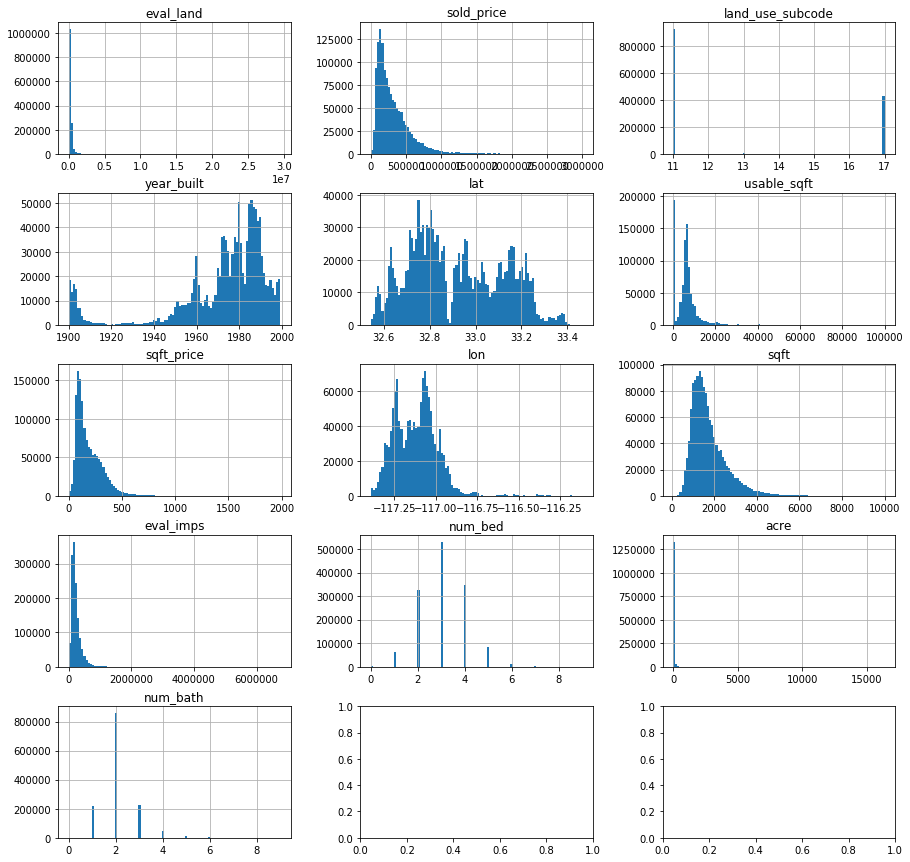

In [6]:
df_all_valid = df_all[(df_all['sqft_price']<2000) &(df_all['sqft_price']>0)
                     &(df_all['sqft']<10000)
                     &(df_all['sold_price']>0) 
                     &(df_all['sold_price'] < 3000000)
                     &(df_all['num_bed']<10)
                     &(df_all['num_bath']<10)
                     &(df_all['lon'].notnull())
                     ]
plot_feature_histogram(df_all_valid, list(columns))

In [7]:
print(df_all.shape)
print(df_all_valid.shape)

(1512560, 25)
(1369868, 25)


{'sold_price': 1445753, 'sqft_price': 1448693, 'sqft': 1511550, 'num_bed': 1511762, 'num_bath': 1512009, 'lon': 1434716, 'total': 1512560}


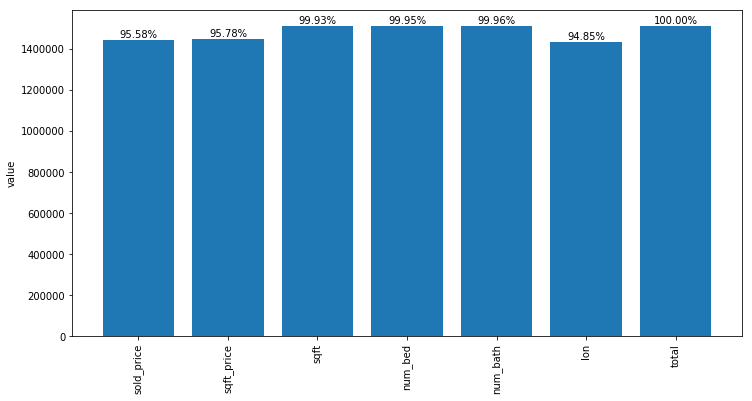

In [8]:
# check valid data size for each valid condition
pp = Preprocess(df_all)
valid_counts = pp.get_valid_count()
print(valid_counts)
plot_bar(valid_counts)

In [9]:
# check the preprocess module set correct condition for valid range
df_all_valid1 = pp.dataset(feature='delivered', valid=True)
print(df_all_valid.shape[0])
print(df_all_valid1.shape[0])

[dp] feature 'prop_count_zip' is missing due to preprocess doesn't have df_property


1369868
1369868


In [10]:
# last year transactions 
df_last_year = df_all[(pd.to_datetime(df_all['date']) >= '2016-10-01') & (pd.to_datetime(df_all['date']) < '2017-10-01')]
df_last_year.shape

(41100, 26)

In [11]:
df_last_year[df_last_year['sold_price']==0].shape

(3162, 26)

c:\wenyan\dse_capstone\notebooks\EDA\../..\src\preprocessing.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.df_transaction['id'] = df_transaction.index


{'sold_price': 37659, 'sqft_price': 37918, 'sqft': 41081, 'num_bed': 41079, 'num_bath': 41088, 'lon': 37358, 'total': 41100}


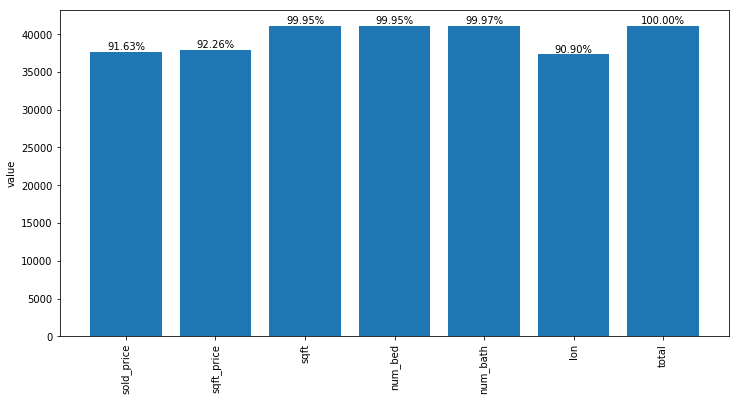

In [15]:
pp_last_year = Preprocess(df_last_year)
valid_counts = pp_last_year.get_valid_count()
print(valid_counts)
plot_bar(valid_counts)

In [17]:
df_last_year.columns

Index(['pin', 'land_use_subcode', 'year_built', 'sqft', 'usable_sqft', 'acre',
       'num_bed', 'num_bath', 'pool', 'view', 'eval_land', 'eval_imps',
       'str_no', 'street', 'st_type', 'unit_no', 'city', 'zip', 'address',
       'new_address', 'lon', 'lat', 'sold_price', 'date', 'sqft_price', 'id'],
      dtype='object')

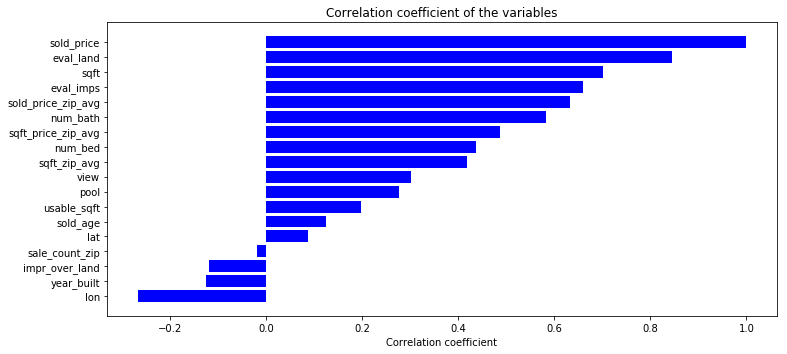

{'eval_imps': 0.6600586283332218,
 'eval_land': 0.8442380827263479,
 'impr_over_land': -0.11860108450546814,
 'lat': 0.08774732537010684,
 'lon': -0.26705963657413323,
 'num_bath': 0.5819884438183561,
 'num_bed': 0.43749276535232345,
 'pool': 0.27763879101691397,
 'sale_count_zip': -0.018721610306162415,
 'sold_age': 0.12559705491770715,
 'sold_price': 0.9999999999999999,
 'sold_price_zip_avg': 0.6332028258343614,
 'sqft': 0.7010625752820957,
 'sqft_price_zip_avg': 0.48735008352024356,
 'sqft_zip_avg': 0.41936169780266835,
 'usable_sqft': 0.1971520406410123,
 'view': 0.30208830688972027,
 'year_built': -0.12450231187927197}

In [22]:
features = set(pp_last_year.get_feature_list('all')) - set(['date', 'street', 'zip', 'sold_year', 'sqft_price']) # exclude features not suitable
plot_correlation(pp_last_year.dataset(valid=True), 'sold_price', features)

In [23]:
features = pp_last_year.get_feature_list('delivered') + ['zip', 'sqft_price']
df_last_year_valid = pp_last_year.dataset(feature_set=features, valid=True)
print(df_last_year_valid.shape[0])

34192


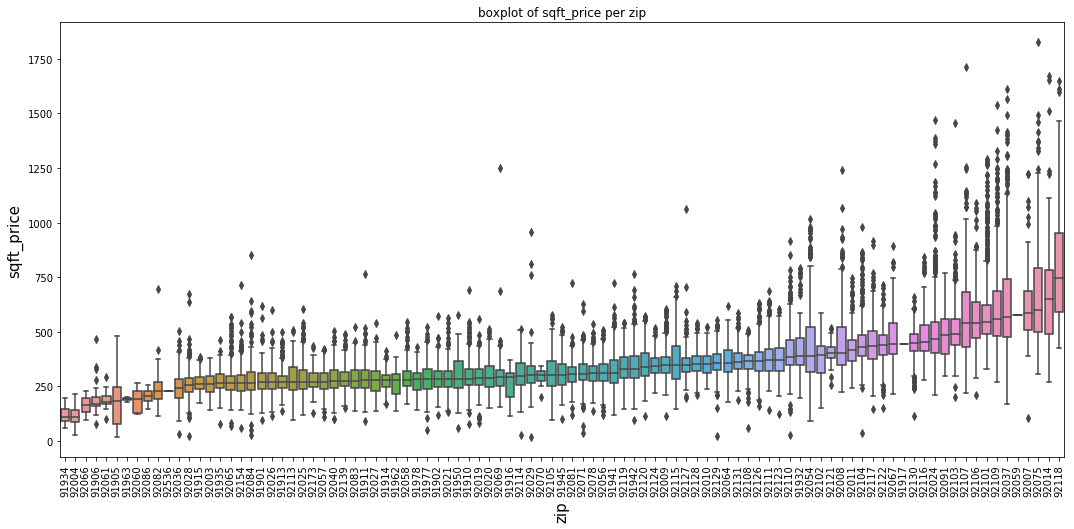

In [93]:
### handling outliers per zip
plot_box(df_last_year_valid, 'zip', 'sqft_price', order=True)

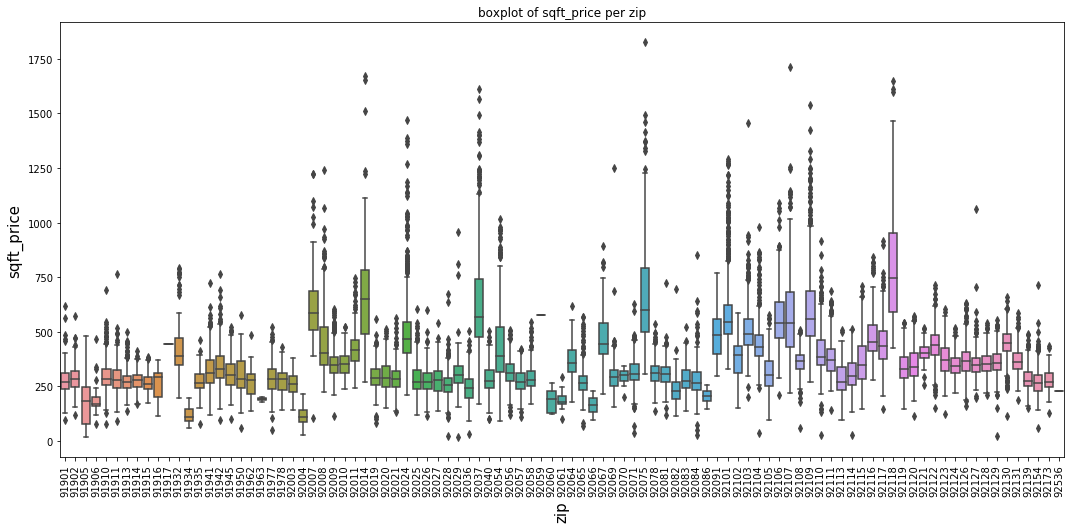

In [99]:
### handling outliers per zip
plot_box(df_last_year_valid, 'zip', 'sqft_price')

In [98]:
df_zip_count.loc['92111']

467

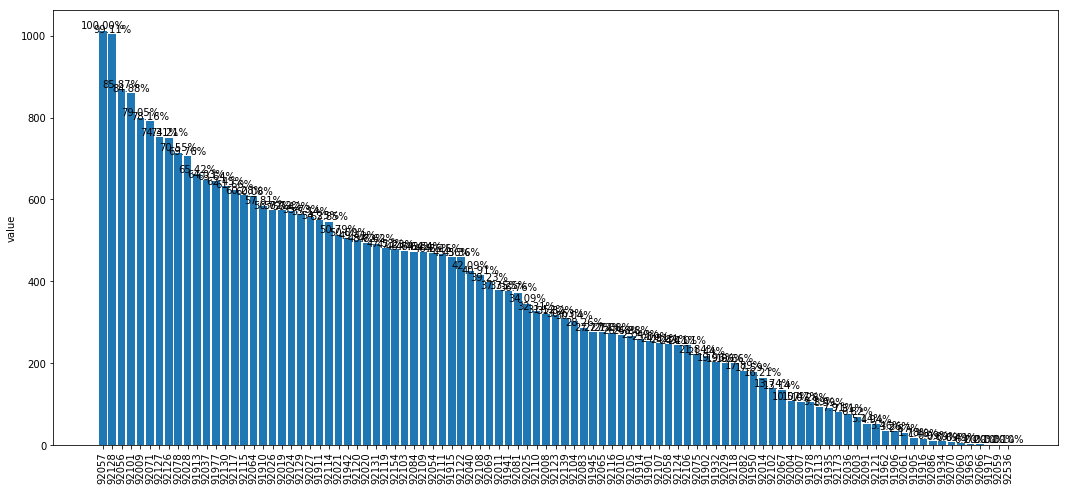

In [78]:
df_zip_count = df_last_year_valid.groupby('zip')['sqft_price'].agg('count')
plot_bar(df_zip_count, ascending=False)

In [88]:
zips = df_last_year_valid['zip'].unique()

def remove_outlier(df, column='sqft_price'):
    q75, q25 = np.percentile(df[column], [75 ,25])
    iqr = q75 - q25
    county_min = q25 - (iqr*1.5)
    county_max = q75 + (iqr*1.5)
    
    dfs = []
    for zip in zips:
        df_zip = df[df['zip']==zip]
        q75, q25 = np.percentile(df_zip[column], [75 ,25])
        iqr = q75 - q25
        zip_min = q25 - (iqr*1.5)
        zip_max = q75 + (iqr*1.5)
        if df_zip.shape[0] < 100:
            zip_min = county_min
            zip_max = county_max
        #print(zip, zip_min, zip_max, (q75+q25)/2)
        dfs.append(df_zip[(df_zip[column]>zip_min)&(df_zip[column]<zip_max)])
        
    return pd.concat(dfs)

In [89]:
df_clean = remove_outlier(df_last_year_valid)
print(df_clean.shape)
print(df_last_year_valid.shape)

(33379, 16)
(34192, 16)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C68DF35860>]],
      dtype=object)

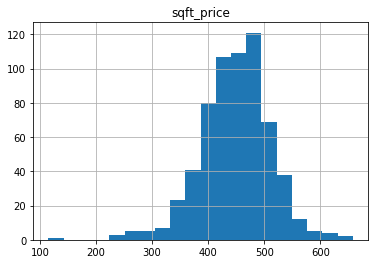

In [90]:
df_last_year_valid[df_last_year_valid['zip']=='92130'].hist('sqft_price', bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C6945737F0>]],
      dtype=object)

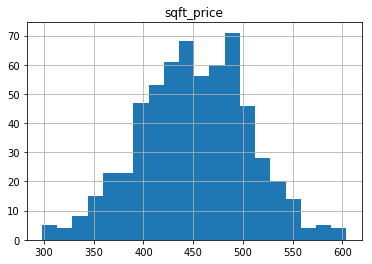

In [91]:
df_clean[df_clean['zip']=='92130'].hist('sqft_price', bins=20)

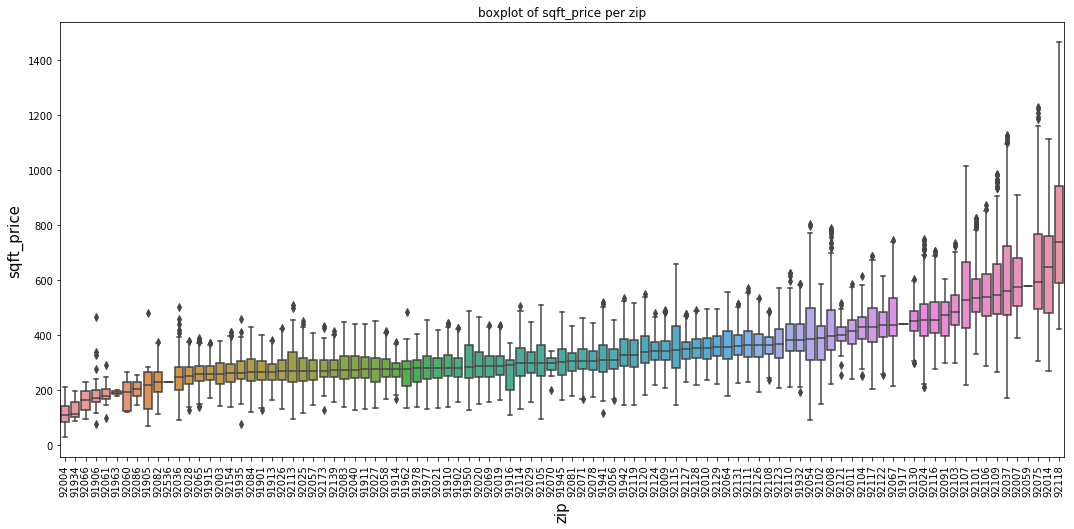

In [94]:
plot_box(df_clean, 'zip', 'sqft_price', order=True)